# Esonero 2 - 17 Maggio 2021

Completare i seguenti esercizi tramite uno o più blocchi di codice descrivendo le operazioni effettuate


# Esercizio 1

Data la seguente immagine, costruire la feature pyramid di gaussiane e descrivere il procedimento

![](figure1.jpg)

# La piramide è una collezione di rappresentazioni di un'immagine strutturate su più livelli , in cui ogni livello ha in genere dimensione pari ad un quarto del livello sottostante.Nella piramide gaussian ogni livello è ottenuto da quello sottostante effettuando filtraggio con kernl gaussiano di deviazione standar sigma e una scalatura di un fattore 0.5. Nell'esempio sottostante applico alla stessa immagine un filtro gaussiano corrispondente a valori crescenti di devianza, su un fattore  2^𝑘 rispetto ad un valore iniziale sigma.L'applicazione dle filtro simula la perdita di  dettagli di un immagine come se guardassimo un oggetto e piano piano ci allontanassimo , noteremo una perdita di dettagli.


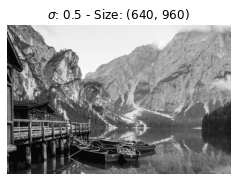

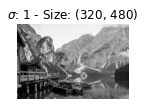

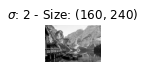

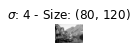

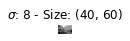

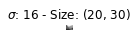

In [7]:
from utils import *
from matplotlib import image as mp_image

image = mp_image.imread('AndreaZofrea/figure1.jpg')
image = rgb2gray(image)

maxv, minv = np.max(image), np.min(image)

image = (image - minv)/(maxv-minv)


sz = 4

num_octave = 6

cur_scale = np.copy(image)
sigma = 0.5

for i in range(num_octave):
    cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
    cur_scale = cur_scale[::2,::2]
    
    plt.figure(figsize=(sz, sz))
    plt.imshow(cur_scale,cmap=cm.gray)
    s = 2*np.ceil(3*2**(i-1))+1
    plt.title(f'$\sigma$: {2**(i-1)} - Size: {cur_scale.shape}')
    plt.axis('off')
    plt.show()
    
    sz = sz/2
    



# La piramide gaussiana è utilizza nell'algoritmo SIFT per l'individuazione delle feature. Sift utilizza la piramide gaussiana per la creazione delle ottave.Suddivide lo scale space in ottave in cui ogni ottava i corrisponde all'applicazione del filtro 2^i sigma. Ogni ottava è suddivisa in un numero s d'intervalli.Esempio s=2  avremmo 3 immagini nell'ottava. Come possiamo vedere nella figura sottostante.

In [8]:
def generate_octave(init_level, s, sigma): 
    octave = [init_level] 
    k = 2**(1/s) 
    for _ in range(s+2): 
        next_level = ndimage.gaussian_filter(octave[-1],k * sigma)
        octave.append(next_level) 
    return octave

def generate_gaussian_pyramid(im, num_octave, s, sigma): 
    pyr = [] 
    for _ in range(num_octave): 
        octave = generate_octave(im, s, sigma) 
        pyr.append(octave) 
        im = octave[-3][::2, ::2] 
    return pyr

def plot_pyramid(p,sz,hspace=10,vspace=10):
    rows, cols = sz[0],sz[1]

    nrows = sum([x[0].shape[0] for x in p]) +  vspace*(num_octave-1)
    ncols = cols*(s+3)+hspace*(s+2)
    output_image = np.ones((nrows,ncols))

    r = 0
    for i in range(len(p)):
        c = 0
        for j in range(len(p[i])):
            w,h = p[i][j].shape
            output_image[r:r+w,c:c+h] = p[i][j]
            c += cols + hspace
        r += w + vspace
    
    return output_image



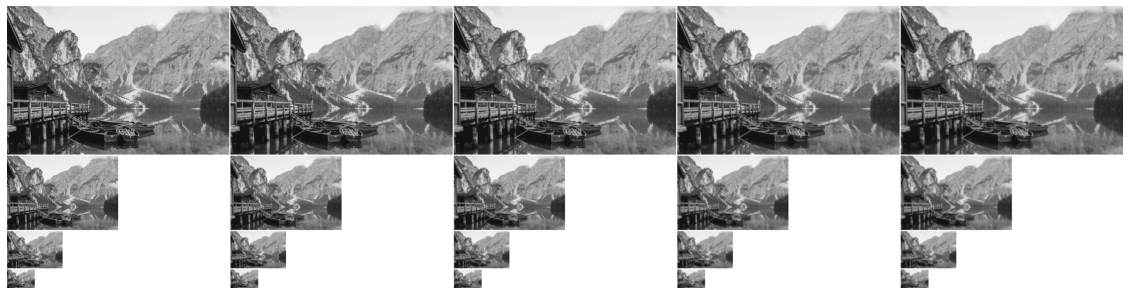

In [9]:
num_octave = 4
s = 2
sigma = 1

p = generate_gaussian_pyramid(image,num_octave,s,sigma)

output_pyr = plot_pyramid(p,image.shape)

fig = plt.figure(figsize=(20, 20))

plt.imshow(output_pyr,cmap=cm.gray)
plt.axis('off')
plt.show()

# Come possiamo vedere dall'immagine lungo le colonne abbiamo delle piramidi gaussiane in cui vengono convolute iterativamente  con un filtro gaussiano di devianza ksigma. Mentre ogni riga inizia con la terz'ultima immagine della riga precedente campionta al 50%.Sift costruisce tutto cio per il calcolo del laplaciano in maniera efficente e semplificata tramite DOG differenze di gaussiane.

# Esercizio 2


Data la seguente sequenza di tensori e la funzione *f*, calcolare il gradiente per i tensori a,b,c,d,e,y. 

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita. 

$
y = f(a,b,c,d,e) = \sum \frac {a^5 + \exp(b^5) * \cos (c*d)} {3e}
$

*non sono necessarie librerie esterne*

# Pythorch utilizza la differenzazione automatica , cio significa che si crea un grado di computazione e all'interno vengono memorizzate le varie operaizioni nell'ordine in cui devono essere eseguite.Ogni nodo rappresenta l'operazione da effettuare collegata agli input dell'operazione. Ad ogni nodo corrisponde un tensore in cui viene memorizzato il risultato.Ogni nodo ha 2 variabili:(grad) che contine il valore del gradiente calcolato e la secondo contiene il riferimento alla funzione vera e propria che deve essere eseguita.


# Per quanto riguarda il calcolo delle derivate si effettuano 2 fasi. La fase di FORWARD per calcolare tutti i valori e un fase BACKWARD per costruire tutte le derivate parziali. Le derivate parziali vengono calcolare tramite la regola della catena che determina una derivata parziale moltiplicando le derivate su un cammino. E la regola della distribuzione che calcola la derivata con somme di 2 cammini.

In [11]:
import torch
import numpy as np
import torch
import torch.nn as nn


a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
a.retain_grad()

b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b.retain_grad()

c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
c.retain_grad()

d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
d.retain_grad()

e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e.retain_grad()

z1=torch.pow(a,2)
z1.retain_grad()


z2=torch.exp(torch.pow(b,2))
z2.retain_grad()


z3=torch.cos(c*d)
z3.retain_grad()


z4=z1+(z2*z3)
z4.retain_grad()

z5=e*3
z5.retain_grad()


z6=z4/z5
z6.retain_grad()


y=torch.sum(z6)

y.backward()


#mostro alcuni esempi in maniera esplicita
agrad=(z5/(torch.pow(z5,2))*(a*2))
print(agrad)
print(a.grad)
print()

bgrad=((z5/(torch.pow(z5,2)))*z3*(2*torch.exp(torch.pow(b,2))*b))
print(bgrad)
print(b.grad)


print()
print(c.grad)

print()
print(d.grad)

print()
print(e.grad)



tensor([[0.6667, 2.0000],
        [4.6667, 5.3333],
        [0.6667, 1.3333]], grad_fn=<MulBackward0>)
tensor([[0.6667, 2.0000],
        [4.6667, 5.3333],
        [0.6667, 1.3333]])

tensor([[-1.3488e+03,  1.2499e+03],
        [ 0.0000e+00,  1.5462e+00],
        [ 1.4552e+16, -7.2069e+01]], grad_fn=<MulBackward0>)
tensor([[-1.3488e+03,  1.2499e+03],
        [ 0.0000e+00,  1.5462e+00],
        [ 1.4552e+16, -7.2069e+01]])

tensor([[-9.8242e+02,  8.0061e+03],
        [-0.0000e+00,  3.7806e+00],
        [ 2.3133e+15, -2.5683e+00]])

tensor([[-4.9121e+02,  6.6718e+03],
        [-0.0000e+00,  3.3080e+00],
        [ 3.0844e+15, -7.7049e+00]])

tensor([[ 4.4628e+01, -1.0716e+02],
        [-1.6667e+01, -2.2106e+01],
        [-1.2127e+15,  1.6684e+01]])


# Esercizio 3

Dati due batch A e B, mostrare gli effetti della BN.

Suggerimento: calcolare gli istogrammi di A e B

In [ ]:
batch1=torch.rand(1000,32,400,400)
batchNorm=nn.BatchNorm2d(32)
batch2=torch.rand(100,32,400,400)

res1=batchNorm(batch1)

res2=batchNorm(batch2)




# Esercizio 4

Dato il seguente frammento di codice

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio. 

In [12]:
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

img=torch.rand(1,3,400,400)
model= conv2(conv1(img))

print(model.shape)

#otteniamo questo tensore 1X30X66X50 che è ottenuto applicando la seguente formula (I-K-(k-1)(d-1)+2p)/s +1

#primo numero dimensione batch =1 
#secondo numero = numero di feature map/filtri applicati nell'ultima convoluzione = 30 
#terzo numero 
#(400-3-0+2 /2 +1) -3-0+0/3 +1 = 66

#quarto numero
#(400-3-0+2/2+1) -5+2/4 +1 = 50


torch.Size([1, 30, 66, 50])


# Esercizio 5

Adattare/semplificare la rete VGG affinché gestisca un input di immagini 400x400

# Per adattare la Vgg16 all'immagine 400X400 ho modificato gli input dei livelli fullyconnected. Modificando il primo layer Lineare da 512X7X7 che era adattato per le immagini di dimensione 224X224 in 512X12X12 .Perchè naturalmente per l'immagine 400X400 l'output dell'ultimo livello convoluzionale è molto più grande di un immagine 224X224 per cui ho rieseguito i calcoli con la formula utilizzata anche nell'esercizio precedente e trovato i valori.

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

#METODI CHE CI INDICANO IL MUMERO DI PARAMETRI.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test(net,img_size=32):
    x = torch.randn(1,3,img_size,img_size)
    y = net(x)
    print("Input: {}; Output: {}; N. of params: {:,}".format(list(x.size()), list(y.size()), count_parameters(net)))

In [4]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 12 * 12, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [5]:
vgg16 = VGG(make_layers(cfg['D']))

test(vgg16,400)

Input: [1, 3, 400, 400]; Output: [1, 1000]; N. of params: 337,586,984


#### Esercizio 6

Data la seguente immagine, calcolare la IoU tra i due box mostrati in figura. 
Descrivere tutte le operazioni effettuate

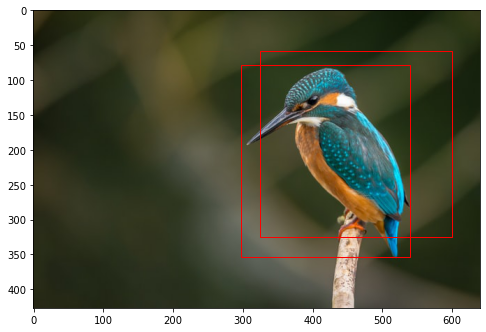

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import matplotlib.patches as patches

def plot_bbox(image_np, bbox_list):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8, 8)

    ax.imshow(image_np)

    for bbox_idx in range(bbox_list.shape[0]):
        x1, y1, x2, y2 = bbox_list[bbox_idx, :].tolist()

        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

        ax.add_patch(rect)

    plt.show();

imageBB1 = mp_image.imread('AndreaZofrea/figure2.jpg')

bb1 = [297, 79, 540, 354]
bb2 = [325, 59, 600, 325]

plot_bbox(imageBB1, np.array([bb1, bb2]))

In [19]:
areaAncora =(bb1[2]-bb1[0])*(bb1[3]-bb1[1])

x1 = max(bb1[1], bb2[1])
y1 = max(bb1[0], bb2[0])
x2 = min(bb1[3], bb2[3])
y2 = min(bb1[2], bb2[2])
areaBox =(bb2[2]-bb2[0])*(bb2[3]-bb2[1])
if (x1 < x2) and (y1 < y2):
    areaInt = (y2 - y1) * (x2 - x1)
    iou = iter_area / (areaAncora + areaBox - areaInt)
else:
    iou = 0.
print(iou)

0.6073376586094046
